### Team of Agents with a supervisor

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class TransferNewsGrader(BaseModel):
    """Binary score for relevance check on football transfer news."""

    binary_score: str = Field(
        description="The article is about football transfers, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(TransferNewsGrader)

system = """You are a grader assessing whether a news article concerns a football transfer. \n
    Check if the article explicitly mentions player transfers between clubs, potential transfers, or confirmed transfers. \n
    Provide a binary score 'yes' or 'no' to indicate whether the news is about a football transfer."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "News Article:\n\n {article}")
    ]
)
evaluator = grade_prompt | structured_llm_grader
result = evaluator.invoke({"There are rumors messi will switch from real madrid to FC Barcelona"})

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class ArticlePostabilityGrader(BaseModel):
    """Binary scores for postability check, word count, sensationalism, and language verification of a news article."""

    can_be_posted: str = Field(
        description="The article is ready to be posted, 'yes' or 'no'"
    )
    meets_word_count: str = Field(
        description="The article has at least 200 words, 'yes' or 'no'"
    )
    is_sensationalistic: str = Field(
        description="The article is written in a sensationalistic style, 'yes' or 'no'"
    )
    is_language_german: str = Field(
        description="The language of the article is German, 'yes' or 'no'"
    )

llm_postability = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_postability_grader = llm_postability.with_structured_output(ArticlePostabilityGrader)

postability_system = """You are a grader assessing whether a news article is ready to be posted, if it meets the minimum word count of 200 words, is written in a sensationalistic style, and if it is in German. \n
    Evaluate the article for grammatical errors, completeness, appropriateness for publication, and EXAGERATED sensationalism. \n
    Also, confirm if the language used in the article is German and it meets the word count requirement. \n
    Provide four binary scores: one to indicate if the article can be posted ('yes' or 'no'), one for adequate word count ('yes' or 'no'), one for sensationalistic writing ('yes' or 'no'), and another if the language is German ('yes' or 'no')."""
postability_grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", postability_system),
        ("human", "News Article:\n\n {article}")
    ]
)

news_chef = postability_grade_prompt | structured_llm_postability_grader

result = news_chef.invoke({"article": "Es wurde gemeldet, dass Messi von Real Madrid zu FC Barcelona wechselt."})

In [3]:
llm_translation = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

translation_system = """You are a translator converting articles into German. Translate the text accurately while maintaining the original tone and style."""
translation_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", translation_system),
        ("human", "Article to translate:\n\n {article}")
    ]
)

translator = translation_prompt | llm_translation

result = translator.invoke({"article": "It has been reported that Messi will transfer from Real Madrid to FC Barcelona."})
print(result)

content='Es wurde berichtet, dass Messi von Real Madrid zum FC Barcelona wechseln wird.' response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 51, 'total_tokens': 69}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-2baeab56-df76-4fe2-99f1-2e9e1f448147-0'


In [4]:
llm_expansion = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.5)
expansion_system = """You are a writer tasked with expanding the given article to at least 200 words while maintaining relevance, coherence, and the original tone."""
expansion_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", expansion_system),
        ("human", "Original article:\n\n {article}")
    ]
)

expander = expansion_prompt | llm_expansion

article_content = "Lionel Messi is reportedly considering a move from Real Madrid to FC Barcelona next season."
result = expander.invoke({"article": article_content})
print(result)

content="Reports have emerged suggesting that Lionel Messi is contemplating a transfer from Real Madrid to FC Barcelona for the upcoming season. This potential move has sparked immense excitement and speculation among football fans worldwide. Messi, widely regarded as one of the greatest footballers of all time, has had a storied career at Real Madrid, but the prospect of him returning to his former club, FC Barcelona, where he achieved numerous successes and accolades, is truly captivating.\n\nIf this transfer indeed materializes, it would undoubtedly be a significant moment in football history, with Messi donning the iconic colors of FC Barcelona once again. The rivalry between Real Madrid and FC Barcelona is one of the most intense and storied in football, adding an extra layer of drama and intrigue to this potential move. Fans on both sides are eagerly awaiting further developments and confirmation regarding Messi's decision.\n\nAs discussions and negotiations unfold, the footballi

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal

class AgentState(TypedDict):
    article_state: str

In [6]:
def get_transfer_news_grade(state: AgentState) -> AgentState:
    print(f"get_transfer_news_grade: Current state: {state}")
    print("Evaluator: Reading article but doing nothing to change it...")
    return state

In [7]:
def evaluate_article(state: AgentState) -> AgentState:
    print(f"evaluate_article: Current state: {state}")
    print("News : Reading article but doing nothing to change it...")
    return state

In [8]:
def translate_article(state: AgentState) -> AgentState:
    print(f"translate_article: Current state: {state}")
    article = state["article_state"]
    result = translator.invoke({"article": article})
    state["article_state"] = result.content
    return state

In [9]:
def expand_article(state: AgentState) -> AgentState:
    print(f"expand_article: Current state: {state}")
    article = state["article_state"]
    result = expander.invoke({"article": article})
    state["article_state"] = result.content
    return state

In [10]:
def publisher(state: AgentState) -> AgentState:
    print(f"publisher: Current state: {state}")
    print("FINAL_STATE in publisher:", state)
    return state

In [11]:
def evaluator_router(state: AgentState) -> Literal["news_chef", "not_relevant"]:
    article = state["article_state"]
    evaluator = grade_prompt | structured_llm_grader
    result = evaluator.invoke({"article": article})
    print(f"evaluator_router: Current state: {state}")
    print("Evaluator result: ", result)
    if result.binary_score == 'yes':
        return "news_chef"
    else:
        return "not_relevant"

In [12]:
def news_chef_router(state: AgentState) -> Literal["translator", "publisher", "expander"]:
    article = state["article_state"]
    result = news_chef.invoke({"article": article})
    print(f"news_chef_router: Current state: {state}")
    print("News chef result: ", result)
    if result.can_be_posted == 'yes':
        return "publisher"
    elif result.is_language_german == 'yes':
        if result.meets_word_count == 'no' or result.is_sensationalistic == 'no':
            return "expander"
    return "translator"

In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("evaluator", get_transfer_news_grade)
workflow.add_node("news_chef", evaluate_article)
workflow.add_node("translator", translate_article)
workflow.add_node("expander", expand_article)
workflow.add_node("publisher", publisher)

workflow.set_entry_point("evaluator")

workflow.add_conditional_edges(
    "evaluator",
    evaluator_router,
    {"news_chef": "news_chef", "not_relevant": END}
)
workflow.add_conditional_edges(
    "news_chef",
    news_chef_router,
    {"translator": "translator", "publisher": "publisher", "expander": "expander"}
)
workflow.add_edge("translator", "news_chef")
workflow.add_edge("expander", "news_chef")
workflow.add_edge("publisher", END)

app = workflow.compile()

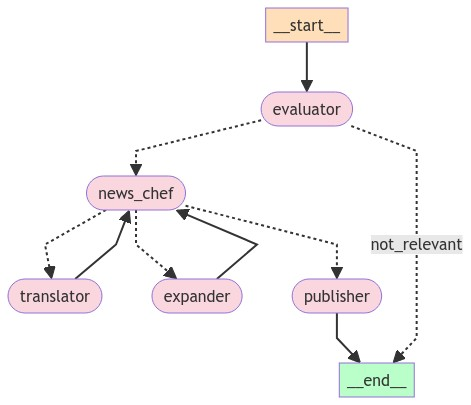

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [15]:
initial_state = {"article_state": "The Pope will visit Spain today"}
result = app.invoke(initial_state)

print("Final result:", result)

get_transfer_news_grade: Current state: {'article_state': 'The Pope will visit Spain today'}
Evaluator: Reading article but doing nothing to change it...
evaluator_router: Current state: {'article_state': 'The Pope will visit Spain today'}
Evaluator result:  binary_score='no'
Final result: {'article_state': 'The Pope will visit Spain today'}


In [16]:
initial_state = {"article_state": "Messi gonna switch from barca to real madrid"}
result = app.invoke(initial_state)

print("Final result:", result)

get_transfer_news_grade: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
Evaluator: Reading article but doing nothing to change it...
evaluator_router: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
Evaluator result:  binary_score='yes'
evaluate_article: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
News : Reading article but doing nothing to change it...
news_chef_router: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
News chef result:  can_be_posted='no' meets_word_count='no' is_sensationalistic='yes' is_language_german='no'
translate_article: Current state: {'article_state': 'Messi gonna switch from barca to real madrid'}
evaluate_article: Current state: {'article_state': 'Messi wechselt von Barca zu Real Madrid'}
News : Reading article but doing nothing to change it...
news_chef_router: Current state: {'article_state': 'Messi wechselt von Barca zu 